# Adaptive Linear Neuron (ADALINE)

### Download Iris dataset
Follow the link and download the Iris dataset:  
http://archive.ics.uci.edu/ml/machine-learning-databases/iris/

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
class Adaline:

    def __init__(self, alpha=0.0001, epsilon=0.1, max_iter=300):
        self.alpha = alpha
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.intercept_ = None
        self.coef_ = None
        self.iter = None

    def fit(self, X, y):
        self.intercept_ = np.random.sample()
        self.coef_ = np.random.sample((len(X.T), 1))
        y = y.reshape(-1, 1)
        self.iter = 0

        while True:
            self.iter += 1
            if self.iter > self.max_iter:
                break

            z = self._z(X)
            y_cap = self._phi(z)
            
            delta_b = self.alpha * (y - y_cap).sum()
            delta_w = self.alpha * X.T.dot(y - y_cap)
            self.intercept_ += delta_b
            self.coef_ += delta_w
            
            if (delta_b ** 2) + (delta_w ** 2).sum() < self.epsilon:
                break
                
        return self

    # weighted input function
    def _z(self, X):
        return X.dot(self.coef_) + self.intercept_
    
    # activation functions
    def _phi(self, z):
        return z

    # quantizer
    def _q(self, a):
        return np.where(a < 0, -1, 1)
    
    def predict(self, X):
        z = self._z(X)
        y_cap = self._phi(z)
        q = self._q(y_cap)    
        return q.reshape(1, -1)[0]

## Importing data

In [3]:
X = pd.read_csv('datasets/iris.data.csv')
X = X[X['class'].isin(['Iris-setosa', 'Iris-versicolor'])]
X['class'] = np.where(X['class'] == 'Iris-setosa', -1, 1)

In [4]:
x_fields = ['sepal length', 'petal width']

## Without standardisation

### Slicing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X[x_fields]), np.array(X['class']), test_size=0.2)

### Fitting

In [6]:
model = Adaline(alpha=0.0005, epsilon=0.0001).fit(X_train, y_train)

### Performance

In [7]:
print('total iterations', model.iter)
print('train set accuracy', accuracy_score(y_train, model.predict(X_train)))
print('test set accuracy', accuracy_score(y_test, model.predict(X_test)))

total iterations 64
train set accuracy 1.0
test set accuracy 1.0


### Scatterplot

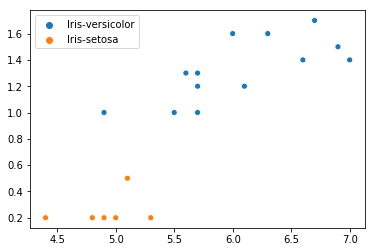

In [8]:
sns.scatterplot(x=X_test.T[0], y=X_test.T[1], hue=np.where(model.predict(X_test) == -1, 'Iris-setosa', 'Iris-versicolor'))

## With standardisation

### Preprocessing

In [9]:
X[x_fields] = StandardScaler().fit_transform(X[x_fields])

### Slicing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X[x_fields]), np.array(X['class']), test_size=0.2)

### Fitting

In [11]:
model = Adaline(alpha=0.01, epsilon=0.01).fit(X_train, y_train)

### Performance

In [12]:
print('total iterations', model.iter)
print('train set accuracy', accuracy_score(y_train, model.predict(X_train)))
print('test set accuracy', accuracy_score(y_test, model.predict(X_test)))

total iterations 3
train set accuracy 1.0
test set accuracy 1.0


### Scatterplot

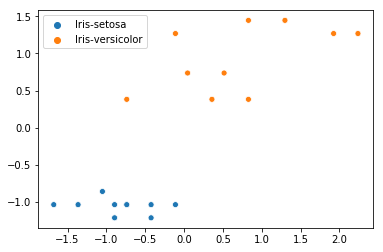

In [13]:
sns.scatterplot(x=X_test.T[0], y=X_test.T[1], hue=np.where(model.predict(X_test) == -1, 'Iris-setosa', 'Iris-versicolor'))

## Linearly inseparable classes

In [14]:
X = pd.read_csv('datasets/iris.data.csv')
X = X[X['class'].isin(['Iris-virginica', 'Iris-versicolor'])]
X['class'] = np.where(X['class'] == 'Iris-virginica', -1, 1)

In [15]:
x_fields = ['sepal length', 'sepal width']

### Preprocessing

In [16]:
X[x_fields] = StandardScaler().fit_transform(X[x_fields])

### Slicing

In [17]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X[x_fields]), np.array(X['class']), test_size=0.2)

### Fitting

In [18]:
model = Adaline(alpha=0.01, epsilon=0.01).fit(X_train, y_train)

### Performance

In [19]:
print('total iterations', model.iter)
print('train set accuracy', accuracy_score(y_train, model.predict(X_train)))
print('test set accuracy', accuracy_score(y_test, model.predict(X_test)))

total iterations 4
train set accuracy 0.75
test set accuracy 0.6


### Scatterplot predicted

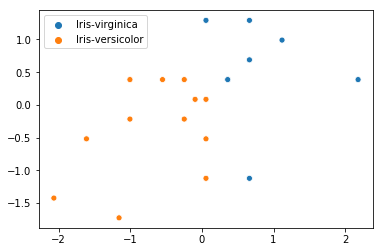

In [20]:
sns.scatterplot(x=X_test.T[0], y=X_test.T[1], hue=np.where(model.predict(X_test) == -1, 'Iris-virginica', 'Iris-versicolor'))

### Scatterplot actual

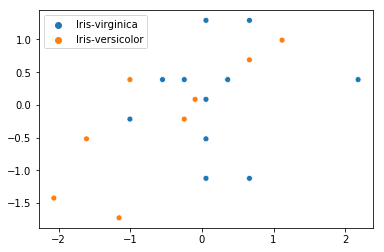

In [21]:
sns.scatterplot(x=X_test.T[0], y=X_test.T[1], hue=np.where(y_test == -1, 'Iris-virginica', 'Iris-versicolor'))